## Lab 3 - A Regression Study of COVID-19
Authors - David Knapp, Andreas Lemos, Julian Tsang

## Research Question
### Which factors and policies are conducive to states' efforts to flatten the epidemic curve?

One of the main strategies to deal with the COVID-19 pandemic was to "flatten the curve." In efforts to slow down the infection rate of the coronavirus, public health measures such as social distancing and stay-at-home orders were mandated to reduce the peak of the epidemic curve. Doing so allowed more time for healthcare services and hospitals to increase capacity and to better cope with influxes of patients. Reducing the probability of exposure to the virus during a pandemic meant that more quality care can be better suited to meet surging demand and that the health care system would not be overwhelmed at once. <br>

We would like to investigate how effectively different states in the country were able to flatten the curve. Based on the available data, the premise of our analysis is hinged upon our assumption that the rate of deaths per case is a suitable metric to gauge every state's handling of the pandemic. How a state handles its public health measures will not only affect how many of its citizens contract the virus, but also how well its medical system can suitably care for patients and prevent deaths. We assume that a state that is better equipped to flatten the curve will have a lower rate of deaths per case. <br>

Deaths per case is calculated by:
$$ Deaths per Case = \frac{Total Deaths}{Total Cases}$$
<br>
Using this metric, we will consider which factors and/or policies were most conducive to flattening the curve.


For our analysis, we will use a dataset compiled from multiple sources such as the United States Center for Disease Control, Boston University, and the American Hospital Directory. 

The dataset includes (1) variables representing the spread of the disease, (2) variables representing state-level policy responses, and (3) general state-level characteristics.

There are limitations within the dataset since the data is a snapshot of the coronavirus pandemic on July 6, 2020. Death is a lagging indicator of cases, so it is likely that the ultimate fatality rate for certain states is understated. Furthermore, the true number of positive cases is unknown since we can only measure the number of positive tests. 



## Initial Setup

In [3]:
# Load necessary libraries
library("openxlsx")
library("ggplot2")
library("cowplot")
library("stargazer")
library("car")
library("sandwich")
library("lmtest")
library("dplyr")
library("knitr")
library("magrittr")

In [23]:
# Import Excel File
#setwd("~/desktop/Everything/Cal/W203/lab3")

# Import Excel File
df <- 
    openxlsx::read.xlsx('./covid-19_dist0720.xlsx',sheet = 'Covid-19')

# Reorder columns so new variable is closer to the 'front'
# df <- df[, c(1,2,3,26,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25)]

# Create Response Variable of Interest
df$Deaths_Per_Cases = round(100* df$Total.Death / df$Total.Cases, digits = 4)

names(df)[names(df) == "Stay.at.home/.shelter.in.place"] <- "Start_Stay_Home"
names(df)[names(df) == "End/relax.stay.at.home/shelter.in.place"] <- "End_Stay_Home"
names(df)[names(df) == "Closed.non-essential.businesses"] <- "Close_NE_Businesses"
names(df)[names(df) == "Began.to.reopen.businesses.statewide"] <- "Reopen_NE_Businesses"
names(df)[names(df) == "Mandate.face.mask.use.by.employees.in.public-facing.businesses"] <- "Start_Face_Mask"
names(df)[names(df) == "Weekly.unemployment.insurance.maximum.amount.(dollars)"] <- "Insurance_Max"
names(df)[names(df) == "Population.density.per.square.miles"] <- "Density_Sq_Miles"
names(df)[names(df) == "Percent.living.under.the.federal.poverty.line.(2018)"] <- "Perc_Under_Poverty"
names(df)[names(df) == "Percent.at.risk.for.serious.illness.due.to.COVID"] <- "Perc_At_Risk"

# Clean up dates
df$Start_Stay_Home <- as.Date(df$Start_Stay_Home, origin = "1899-12-30")
df$End_Stay_Home <- as.Date(df$End_Stay_Home,origin = "1899-12-30" )
df$Close_NE_Businesses <- as.Date(df$Close_NE_Businesses,origin = "1899-12-30")
df$Reopen_NE_Businesses <- as.Date(df$Reopen_NE_Businesses,origin = "1899-12-30")
df$Start_Face_Mask <- as.Date(df$Start_Face_Mask,origin = "1899-12-30")

df$Mask_date <- as.numeric(abs(as.Date("2020-01-01") - df$Start_Face_Mask))
df$Mask_date[df$Mask_date == 43831] <- 188 #if values are 0, default to 188 (days until July 6 2020)
# df$Mask_date


# Import Hospital data
hospitalData <- read.csv('./hospitalData.csv')

# Merge hospital data with Covid data
df2 <- merge(df,hospitalData,by = "State",all.x = T)

df2$cases_per_bed <- df2$Total.Cases/df2$Staffed_Beds
df2$beds_per_cases <- df2$Staffed_Beds/df2$Total.Cases

#str(df2)

In [24]:
# Look at the structure of the data
data.frame(variable = names(df),
           class = sapply(df, typeof),
           first_values = sapply(df, function(x) paste0(head(x),  collapse = ", ")),
           row.names = NULL) %>% 
  kable()



|variable              |class     |first_values                                                           |
|:---------------------|:---------|:----------------------------------------------------------------------|
|State                 |character |Alabama, Alaska, Arizona, arizona, Arkansas, California                |
|Total.Cases           |double    |44909, 1138, 83376, 14713, 23814, 260155                               |
|Total.Death           |double    |1009, 16, 1538, 271, 287, 6331                                         |
|Death_100k            |double    |20.6, 2.2, 25.2, 25.2, 9.5, 16                                         |
|CasesInLast7Days      |double    |9804, 284, 28038, 28038, 4504, 53722                                   |
|RatePer100000         |double    |918.8, 154.3, 1367.7, 1367.7, 790.2, 657.7                             |
|totalTestResults      |double    |449886, 122732, 604362, 604362, 338893, 4680138                        |
|State.of.emergency    |do

## Variable Analysis (EDA)

### Explorary Data Analysis - Deaths Per Case
We will start with examining the distribution of our response variable, Deaths Per Case.

Summary for 'Deaths per Cases' variable

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.7255  1.8440  2.8259  3.5658  4.9030  9.2793 

Summary for natural log of 'Deaths per Case' variable

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.3209  0.6119  1.0388  1.0853  1.5898  2.2278 

State with highest deaths_per_case 


,State,Deaths_Per_Cases
8,Connecticut,9.2793


State with lowest deaths_per_case 


,State,Deaths_Per_Cases
46,Utah,0.7255


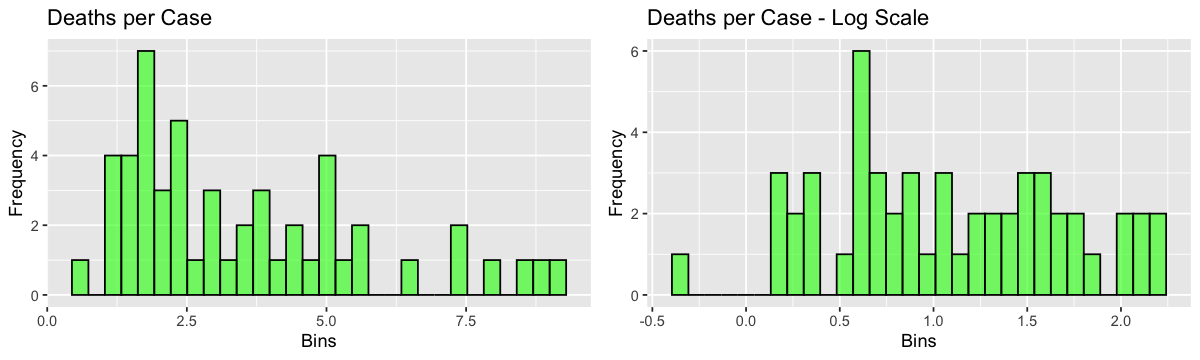

In [25]:
### Examine the 'Deaths per Cases' variable

# Plot sizing
options(repr.plot.height=3, repr.plot.width = 10)

# Summary of Variable
cat("Summary for 'Deaths per Cases' variable")
summary(df$Deaths_Per_Cases)

cat("Summary for natural log of 'Deaths per Case' variable")
summary(log(df$Deaths_Per_Cases))

cat("State with highest deaths_per_case \n") 
df[which.max(df$Deaths_Per_Cases),c('State','Deaths_Per_Cases')]

cat("State with lowest deaths_per_case \n") 
df[which.min(df$Deaths_Per_Cases),c('State','Deaths_Per_Cases')]

# Plot histograms to look at the data
dpc_p <- qplot(df$Deaths_Per_Cases, geom="histogram", main = "Deaths per Case", bins = 30,
               xlab = "Bins", ylab = "Frequency", fill=I("green"), col=I("black"), alpha=I(.6))

dpc_ln_p <- qplot(log(df$Deaths_Per_Cases), geom="histogram", main = "Deaths per Case - Log Scale",  bins = 30,
               xlab = "Bins", ylab = "Frequency", fill=I("green"), col=I("black"), alpha=I(.6))

plot_grid(dpc_p, dpc_ln_p, labels = "")

We can see that *Deaths Per Case* is a continuous numeric variable that has a positive skew. The average state has a rate of 3.56 deaths per 100 cases. The state with the highest case fatality rate is Connecticut and the state with the lowest rate is Utah.
75% of states have a *Deaths Per Case* rate between 1.8% and 4.9%.
<br>

Now, we examine some independent variables that we think will help predict the rate of *Deaths Per Case*.
We begin by looking into *Beds Per Case,* which indicates how equipped hospitals are able to handle a surge of cases during a pandemic.

In [26]:
# beds per cases
summary(df2$beds_per_cases)
cat("Records with missing hospital data: \n",df2$State[is.na(df2$beds_per_cases)])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.1165  0.2319  0.3180  0.4614  0.4554  2.7508       2 

Records with missing hospital data: 
 arizona District of Columbia

We see that we have 2 missing values for *Beds Per Case*: 'District of Columbia' and 'arizona'. <br>
'arizona' is the only record in the dataset that doesn't start with a capital letter. Furthermore, it is a duplicate record so we will remove this row from our analysis. 
As for the District of Columbia, which is not a state, we also do not have hospital data so we will exclude this record as well.

The average state has 0.464 beds per case, and 75% of states have between 0.232 and 0.455 beds per case.

In [27]:
# delete records with missing hospital data
df2 <- df2[!df2$State %in% c('arizona','District of Columbia'),]

Summary for 'Beds per Case' variable

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1165  0.2319  0.3180  0.4614  0.4554  2.7508 

Summary for natural log of 'Beds per Case' variable

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.1496 -1.4616 -1.1457 -1.0560 -0.7891  1.0119 

State with highest beds_per_case 


,State,beds_per_cases
13,Hawaii,2.750799


State with lowest beds_per_case 


,State,beds_per_cases
32,New Jersey,0.1165327


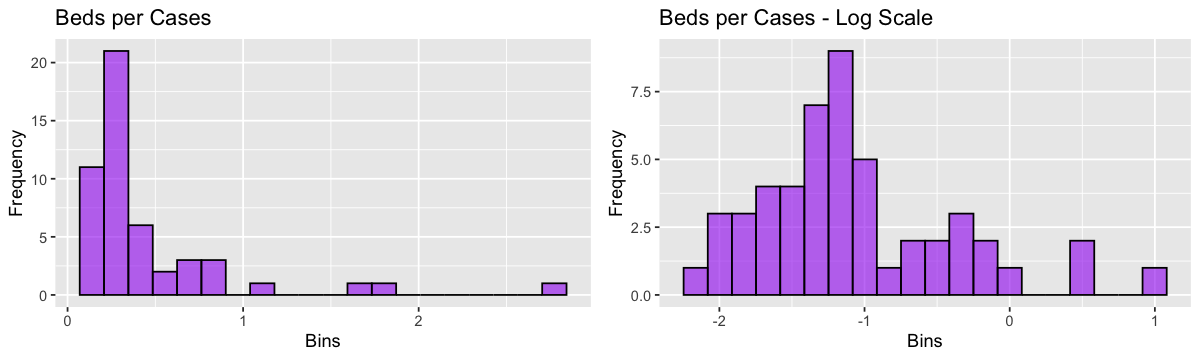

In [28]:
# Plot histograms to look at the data

# Summary of Variable
cat("Summary for 'Beds per Case' variable") 
summary(df2$beds_per_cases)

cat("Summary for natural log of 'Beds per Case' variable") 
summary(log(df2$beds_per_cases))
options(repr.plot.height=3, repr.plot.width = 10)
bpc_p <- qplot(df2$beds_per_cases, geom="histogram", main = "Beds per Cases", bins = 20,
               xlab = "Bins", ylab = "Frequency", fill=I("purple"), col=I("black"), alpha=I(.6))
bpc_ln_p <- qplot(log(df2$beds_per_cases), geom="histogram", main = "Beds per Cases - Log Scale",  bins = 20,
                  xlab = "Bins", ylab = "Frequency", fill=I("purple"), col=I("black"), alpha=I(.6))
plot_grid(bpc_p, bpc_ln_p, labels = "")

cat("State with highest beds_per_case \n")
df2[which.max(df2$beds_per_cases),c('State','beds_per_cases')]

cat("State with lowest beds_per_case \n")
df2[which.min(df2$beds_per_cases),c('State','beds_per_cases')]



We can see that beds per cases is also skewed to the left. The logarithm of beds per case appears closer to normal distribution. Furthermore, Hawaii has by far the most beds per cases at 2.75 beds per case. We will need to monitor how Hawaii would impact our regression.

Next, we will examine the *Perc_At_Risk* variable, which is an indicator of how many people in a state would be susceptible to disease during a pandemic.

Summary for 'Percent at Risk' variable

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  30.00   35.98   38.65   38.16   40.58   49.30 

Summary for natural log of 'Percent at Risk' variable

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.401   3.583   3.655   3.637   3.703   3.898 

State with highest beds_per_case 


,State,Perc_At_Risk
50,West Virginia,49.3


State with lowest beds_per_case 


,State,Perc_At_Risk
46,Utah,30


[1] 3.656529

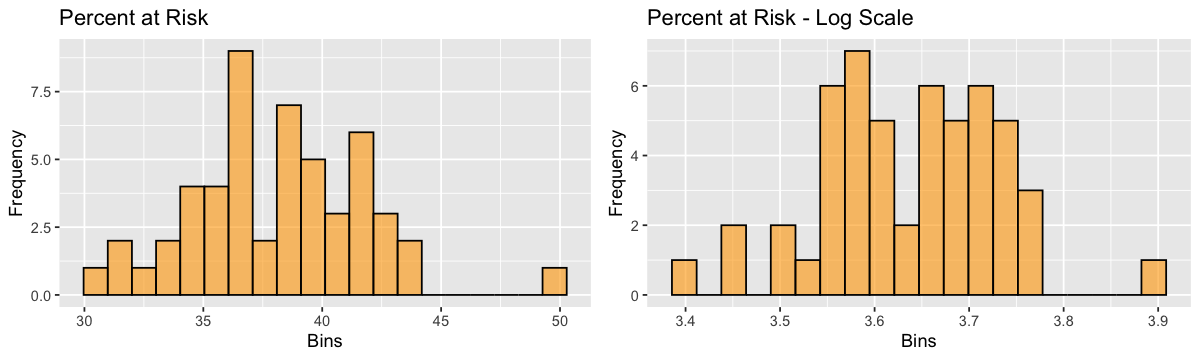

In [7]:
# percent at risk

# Summary of Variable
cat("Summary for 'Percent at Risk' variable") 
summary(df2$Perc_At_Risk)

cat("Summary for natural log of 'Percent at Risk' variable") 
summary(log(df2$Perc_At_Risk))

cat("State with highest beds_per_case \n") 
df2[which.max(df2$Perc_At_Risk),c('State','Perc_At_Risk')]

cat("State with lowest beds_per_case \n") 
df2[which.min(df2$Perc_At_Risk),c('State','Perc_At_Risk')]

sd(df2$Perc_At_Risk,na.rm = T)

# Plot sizing
options(repr.plot.height=3, repr.plot.width = 10)

par_p <- qplot(df2$Perc_At_Risk, geom="histogram", main = "Percent at Risk", bins = 20,
               xlab = "Bins", ylab = "Frequency", fill=I("orange"), col=I("black"), alpha=I(.6))

par_ln_p <- qplot(log(df2$Perc_At_Risk), geom="histogram", main = "Percent at Risk - Log Scale", bins = 20,
               xlab = "Bins", ylab = "Frequency", fill=I("orange"), col=I("black"), alpha=I(.6))
plot_grid(par_p, par_ln_p, labels = "")

The distribution for percent-at-risk population appears approximately normal with a slight positive skew.
The average state has 38.27% of their population at risk, while 75% of states have between 36% and 41%
of their populations at risk for serious illness.

Next, we will examine the variable for unemployment insurance, which indicates the maximum amount of weekly unemployment insurance payouts. 

Summary for 'Insurance Max' variable

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  190.0   368.8   449.0   455.8   525.5   823.0 

Summary for natural log of 'Insurance Max' variable

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  5.247   5.910   6.107   6.073   6.264   6.713 

Insurance Max Standard Deviation

[1] 140.0681

State with highest Insurance Max 


,State,Perc_At_Risk
23,Massachusetts,34.6


State with lowest Insurance Max 


,State,Perc_At_Risk
41,Rhode Island,38.3


[1] 140.0681

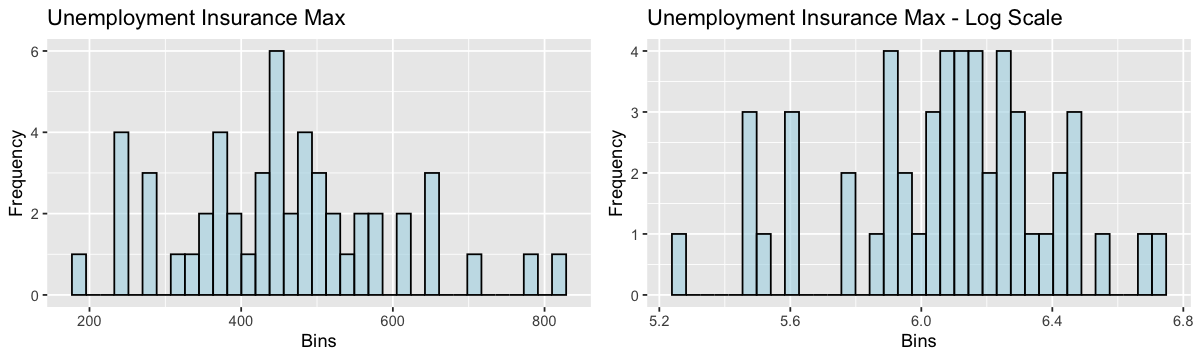

In [8]:
# unemployment insurance

# Summary of Variable
cat("Summary for 'Insurance Max' variable") 
summary(df2$Insurance_Max)

cat("Summary for natural log of 'Insurance Max' variable") 
summary(log(df2$Insurance_Max))

cat("Insurance Max Standard Deviation") 
round(sd(df2$Insurance_Max,na.rm = T), 4)

cat("State with highest Insurance Max \n") 
df2[which.max(df2$Insurance_Max),c('State','Perc_At_Risk')]

cat("State with lowest Insurance Max \n") 
df2[which.min(df2$Insurance_Max),c('State','Perc_At_Risk')]

sd(df2$Insurance_Max,na.rm = T)
# Plot sizing
options(repr.plot.height=3, repr.plot.width = 10)
wuim_p <- qplot(df2$Insurance_Max, geom="histogram", main = "Unemployment Insurance Max", bins = 35,
               xlab = "Bins", ylab = "Frequency", fill=I("light blue"), col=I("black"), alpha=I(.6))
wuim_log_p <- qplot(log(df2$Insurance_Max), geom="histogram", main = "Unemployment Insurance Max - Log Scale", bins = 35,
               xlab = "Bins", ylab = "Frequency", fill=I("light blue"), col=I("black"), alpha=I(.6))

plot_grid(wuim_p, wuim_log_p)

The distribution for unemployment insurance appears approximately normal. The average state has a weeklyn unemployment insurance maximum of \\$460. 75% of states have a weekly unemployment insurance maximum between \\$370 and \\$535.

Next, we examine our variable, *Mask_date*, which indicates the number of days into the 2020 year that states started mandating people to wear masks. If a state did not mandate such a rule, then they have been top-coded to July 6, 2020, which is 188 days into the year.

Summary for 'Mask_date' variable

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   93.0   117.2   124.5   135.0   144.5   188.0 

Summary for natural log of 'Mask_date' variable

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  4.533   4.764   4.824   4.884   4.972   5.236 

States with longest Mask_date 


,State,Mask_date
14,Idaho,188
17,Iowa,188
18,Kansas,188
27,Missouri,188
28,Montana,188
38,Oklahoma,188
42,South Carolina,188
43,South Dakota,188
44,Tennessee,188
51,Wisconsin,188


State with lowest Mask_date 


,State,Mask_date
8,Connecticut,93


[1] 139.4454

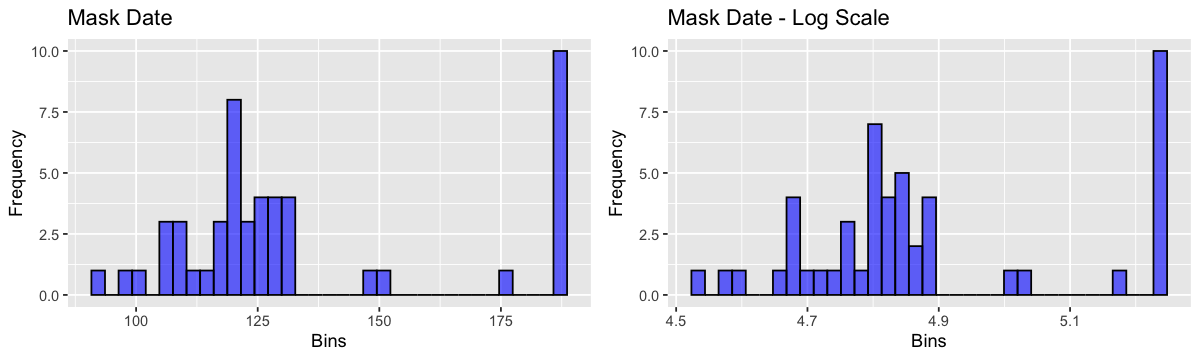

In [10]:
cat("Summary for 'Mask_date' variable") 
summary(df2$Mask_date)

cat("Summary for natural log of 'Mask_date' variable") 
summary(log(df2$Mask_date))

cat("States with longest Mask_date \n") 
df2[df2$Mask_date == 188,c('State','Mask_date')]

cat("State with lowest Mask_date \n") 
df2[which.min(df2$Mask_date),c('State','Mask_date')]

sd(df2$Insurance_Max,na.rm = T)
# Plot sizing
options(repr.plot.height=3, repr.plot.width = 10)
wuim_p <- qplot(df2$Mask_date, geom="histogram", main = "Mask Date", bins = 35,
               xlab = "Bins", ylab = "Frequency", fill=I("blue"), col=I("black"), alpha=I(.6))
wuim_log_p <- qplot(log(df2$Mask_date), geom="histogram", main = "Mask Date - Log Scale", bins = 35,
               xlab = "Bins", ylab = "Frequency", fill=I("blue"), col=I("black"), alpha=I(.6))

plot_grid(wuim_p, wuim_log_p)

There were 10 states that did not institute a mask mandate, whereas Connecticut was the first state to issue one. The average state took 135 days into the year to mandate masks, which is around May 15, 2020. 

## Relationship Between Variables

### Scatter Plots Between Variables
The following shows a scatterplot matrix between the variables we have discussed.

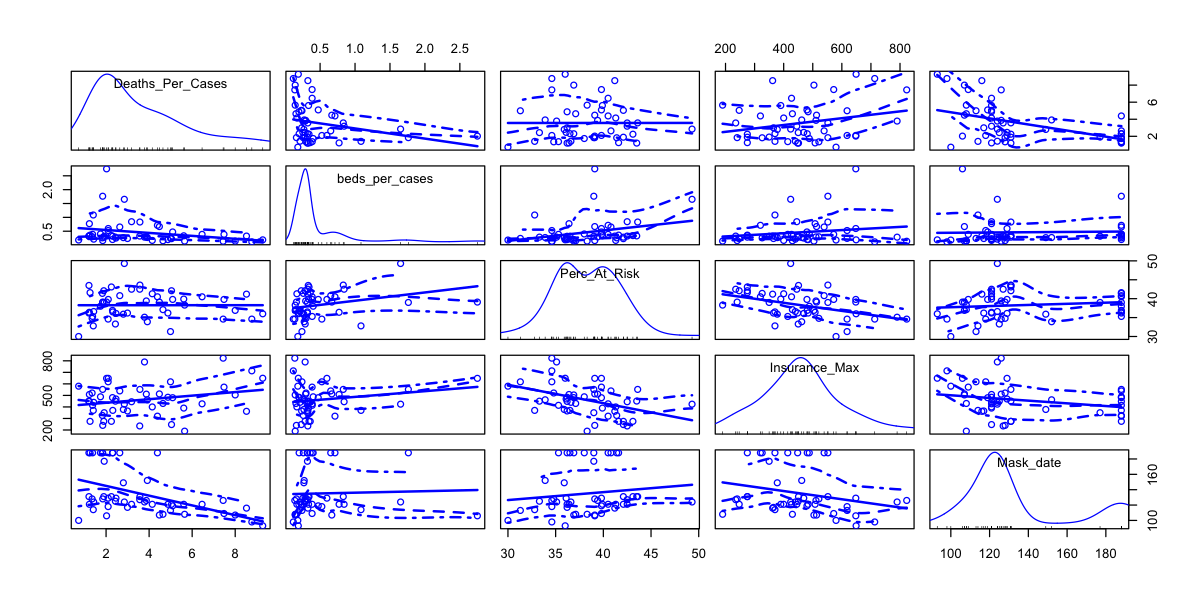

In [35]:
# Plot sizing
options(repr.plot.height=5, repr.plot.width = 10)

# Scatter plots to check correlations 
scatterplotMatrix(df2[ , c("Deaths_Per_Cases", "beds_per_cases", "Perc_At_Risk", "Insurance_Max", "Mask_date")])

#### Relationship between dependent and independent variables:

*Deaths per Case* and *Beds per Case* appear to have a negative linear relationship.
However, a lot of the *Deaths per Case* values appear clustered to the left, suggesting that a transformation
may be needed. <br>

*Deaths per Case* does not appear to have a significant linear relationship with the *Percent at Risk,* which appears counterintuitive since one would expect that if more of the population is at risk for serious illness, then the population would suffer more deaths per case.

*Deaths per Case* appears to have a positive relationship with the unemployment insurance maximum.
This is also surprising.

Finally, *Deaths Per Case* appears to have a negative linear relationship with *Mask_date*, which suggests that as states take longer to mandate the use of masks, then the number of deaths per case decreases. Again, this seems counterintuitive.

#### Relationship between independent variables
We can see that our independent variables do not have perfect multicollinearity.
- *Beds per Case* appears to have a slightly positive correlation with both of our other predictors.
- *Percent at Risk* appears to have a negative correlation with the employment insurance maximum.
- *Mask_date* has a negative correlation with employment insurance maximum, and slightly positive relationships with *Beds Per Case* and *Percent at Risk*.

We can also confirm that our variables do not have perfect multicollinearity by computing their Variance Inflation Factors. 
A rule of thumb for interpreting the variance inflation factor:

- 1 = not correlated.
- Between 1 and 5 = moderately correlated.
- Greater than 5 = highly correlated.


In [70]:
vif(lm2)

log_beds_per_cases       Perc_At_Risk      Insurance_Max          Mask_date 
          1.310660           1.509052           1.409923           1.116505

### Scatter Plots Between Transformed Variables
From what we have observed from our exploratory data analysis and our scatter plots, we can take the natural log and transform two of our variables: *Deaths Per Case* and *Beds Per Case.* It would not make intuitive sense to compute the log transformation for *Percent at Risk*, *Insurance Max*, and *Mask_date*.
Let's take another look at our updated scatter plots using the transformed variables.

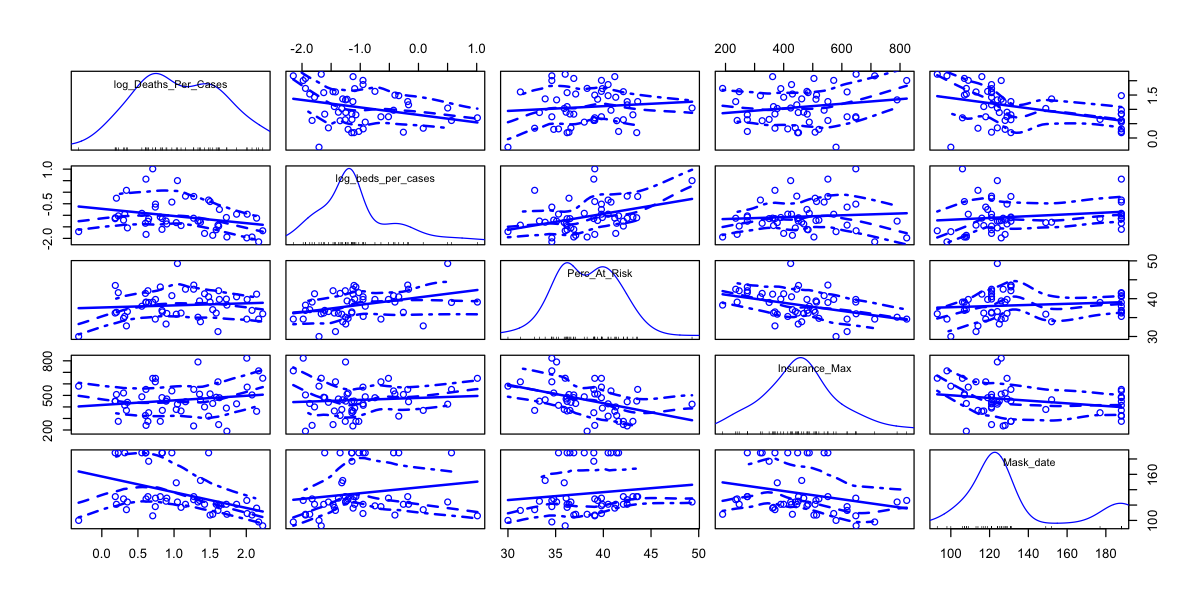

In [36]:
#log transformation for our two variables
df2$log_Deaths_Per_Cases <- log(df2$Deaths_Per_Cases)
df2$log_beds_per_cases <- log(df2$beds_per_cases)

# Plot sizing
options(repr.plot.height=5, repr.plot.width = 10)

# Scatter plots to check correlations 
scatterplotMatrix(df2[ , c("log_Deaths_Per_Cases", "log_beds_per_cases", "Perc_At_Risk", "Insurance_Max", "Mask_date")])


## Linear Models

### Base Model - Model 1
For our base model, we will only measure the effect that *Beds Per Case* has on *Deaths Per Case.*

- Reponse or Dependent variable (Y): 
   - Deaths per Case (Log scale)
- Predictor or Independent variables (X)
   - Number of Beds per number of Case (Log scale)

In [30]:
# model with minumum covariates
lm1 <- lm(log_Deaths_Per_Cases ~ log_beds_per_cases, data = df2) 
summary(lm1)


Call:
lm(formula = log_Deaths_Per_Cases ~ log_beds_per_cases, data = df2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.57458 -0.45382  0.09981  0.42484  1.04239 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)          0.8065     0.1591   5.069 6.36e-06 ***
log_beds_per_cases  -0.2618     0.1269  -2.063   0.0446 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6061 on 48 degrees of freedom
Multiple R-squared:  0.08143,	Adjusted R-squared:  0.06229 
F-statistic: 4.255 on 1 and 48 DF,  p-value: 0.04457


### Balanced Model - Model 2
For our balanced model, we will measure the effects that *Beds Per Case*, *Percent at Risk*, *Insurance Max*, and *Mask_date* have on *Deaths Per Case*.

- Reponse or Dependent variable (Y): 
   - Deaths per Cases (log scale)
- Predictor or Independent variables (X)
   - Number of Beds per number of Cases (Log scale)
   - Percent at Risk
   - Insurance Max
   - Mask_date (number of days into 2020 until masks were mandated)


Call:
lm(formula = log_Deaths_Per_Cases ~ log_beds_per_cases + Perc_At_Risk + 
    Insurance_Max + Mask_date, data = df2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.46495 -0.25948  0.02073  0.34019  1.06509 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)   
(Intercept)        -1.692054   1.317428  -1.284  0.20559   
log_beds_per_cases -0.370128   0.125922  -2.939  0.00518 **
Perc_At_Risk        0.071102   0.025508   2.787  0.00775 **
Insurance_Max       0.001340   0.000639   2.098  0.04157 * 
Mask_date          -0.007066   0.002655  -2.661  0.01076 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5253 on 45 degrees of freedom
Multiple R-squared:  0.3532,	Adjusted R-squared:  0.2957 
F-statistic: 6.144 on 4 and 45 DF,  p-value: 0.0004942


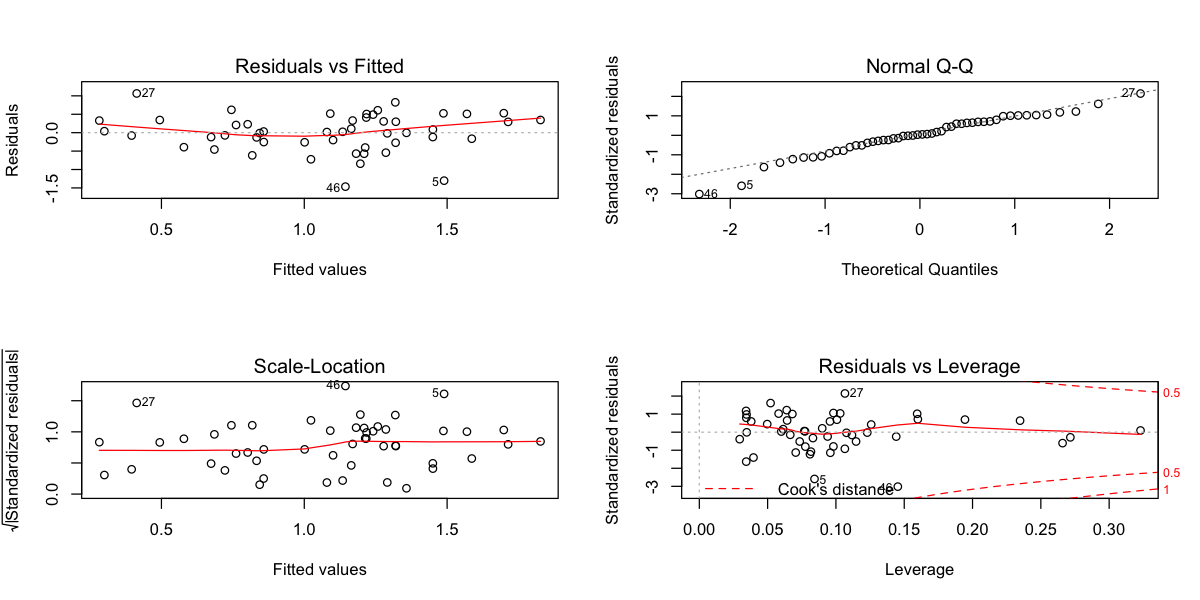

In [31]:
lm2 <- lm(log_Deaths_Per_Cases ~ 
              log_beds_per_cases +
              Perc_At_Risk +
              Insurance_Max +
              Mask_date,
              data = df2)
summary(lm2)
par(mfrow=c(2,2))

options(repr.plot.height=5, repr.plot.width = 10)
plot(lm2)

### Maximalist Model - Model 3
We will use as many covariates as we can on *Deaths Per Case*. 

- Reponse or Dependent variable (Y): 
   - Deaths per Cases (log scale)
- Predictor or Independent variables (X)
   - Number of Beds per number of Cases (Log scale)
   - Percent at Risk
   - Insurance Max
   - Rate per 100,000
   - Density per Squared Miles
   - Percentage Under Poverty
   - Percentage over 65 years old
   - All cause deaths - 2018


In [32]:
# model with maximum covariates
lm3 <- lm(log_Deaths_Per_Cases ~ log_beds_per_cases +
                                 Perc_At_Risk + 
                                 Insurance_Max + 
                                 Mask_date +
                                 RatePer100000 + 
                                 Density_Sq_Miles + 
                                 Perc_Under_Poverty + 
                                 `65+` + 
                                 `All-cause.deaths.2018`
                                 , data = df2) 
summary(lm3)


Call:
lm(formula = log_Deaths_Per_Cases ~ log_beds_per_cases + Perc_At_Risk + 
    Insurance_Max + Mask_date + RatePer100000 + Density_Sq_Miles + 
    Perc_Under_Poverty + `65+` + `All-cause.deaths.2018`, data = df2)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0846 -0.2757  0.0218  0.3159  0.9542 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)  
(Intercept)             -1.162e+00  1.337e+00  -0.869   0.3901  
log_beds_per_cases      -1.066e-01  1.731e-01  -0.616   0.5414  
Perc_At_Risk             5.235e-02  4.680e-02   1.119   0.2700  
Insurance_Max            7.264e-04  6.587e-04   1.103   0.2767  
Mask_date               -4.944e-03  2.692e-03  -1.836   0.0737 .
RatePer100000            1.261e-04  1.685e-04   0.748   0.4587  
Density_Sq_Miles         1.015e-03  5.087e-04   1.995   0.0528 .
Perc_Under_Poverty      -2.080e-02  4.410e-02  -0.472   0.6397  
`65+`                    2.610e+00  5.893e+00   0.443   0.6602  
`All-cause.deaths.2018`

## OLS Assumptions

The OLS Assumptions from Wooldridge are done based on the Balanced Model (Model 2) above. 

#### Assumption 1: Dependent variable is linear in predictors
This is satisfied by our model $log(Deaths\_per\_cases) = \beta_0 + \beta_1log(beds\_per\_cases) + \beta_2Perc\_at\_risk + \beta_3Insurance\_max + \beta_4Mask\_date$
#### Assumption 2: Random Sample
Our data comes from all 50 states so we are not at risk of clustering or autocorrelation.
#### Assumption 3: no perfect multicollinearity 
This is confirmed by our variable selection and that our scatterplot matrix shows no perfect relationship amount our variables. We also computed Variance Inflation Factors for our independent variables and their results show no evidence of multicollinearity.
#### Assumption 4: zero conditional mean
The *Residuals vs Fitted* plot has curvature, but this is likely impacted by the outer data points. This curvature could also be caused by omitted variable bias. 
#### Assumption 5: homoskedasticity: 
Although we can infer homoskedasticity from the Breusch-Pagan test, the *Scale Location* plot shows curvature, which suggests that we may need to use robust standard errors. 
#### Assumption 6: Normality of errors: 
Our QQ plot illustrates that our data is mostly normal, but a few values at the ends are off the diagonal line. We can verify normality with a Shaprio-Wilk test.



In [17]:
bptest(lm2)


	studentized Breusch-Pagan test

data:  lm2
BP = 1.6019, df = 4, p-value = 0.8084


The null hypothesis of the Breusch-Pagan test is that the error variances are all equal (homoskedastic). The alternate hypothesis is that the error variances are not equal (heteroskedastic). From our p-value, the test indicates that we haven't violated our assumption of homoskedasticity. However, erring on the side of caution, our diagnostic plot indicates we should use robust standard errors.

In [18]:
shapiro.test(lm2$residuals)


	Shapiro-Wilk normality test

data:  lm2$residuals
W = 0.96711, p-value = 0.1761


Our null hypothesis is that the residuals come from a normal distribution. 
Our p-value from the Shaprio-Wilk test was 0.1761, so we fail to reject the null hyptohesis. 
Therefore, we have not violated our normality assumption.

### Regression Table
Using the stargazer library, we constuct a regression table to show the summary of our linear regression analysis between our three models. 

In [33]:
# robust standard errors
se.lm1 = coeftest(lm1, vcov = vcovHC)[ , "Std. Error"] 
se.lm2 = coeftest(lm2, vcov = vcovHC)[ , "Std. Error"] 
se.lm3 = coeftest(lm3, vcov = vcovHC)[ , "Std. Error"]
stargazer(lm1,lm2,lm3, type = "text", omit.stat = "f", 
          se = list(se.lm1,se.lm2,se.lm3),
          star.cutoffs = c(0.05, 0.01, 0.001))


                                      Dependent variable:              
                        -----------------------------------------------
                                     log_Deaths_Per_Cases              
                              (1)             (2)             (3)      
-----------------------------------------------------------------------
log_beds_per_cases          -0.262*        -0.370***        -0.107     
                            (0.110)         (0.094)         (0.291)    
                                                                       
Perc_At_Risk                                0.071*           0.052     
                                            (0.033)         (0.055)    
                                                                       
Insurance_Max                               0.001*           0.001     
                                            (0.001)         (0.001)    
                                                               

We observe that for our balanced model, all four independent variables have statistically significant effects. However, the same four variables lose significance in our maximalist model. *Beds Per Case* has the largest practical effect since it has the largest coefficient of our four variables in the balanced model.

## Omitted Variable Bias

Possible omitted variables that could influence the model:
- Ventilators available
- date when a state reached a certain threshold of cases
- treatment differences between states
- mask usage by state
- percentage of ICU beds available
- GDP by state or per capita income

Example:

Let our model be $log(deaths\_per\_cases) = \beta_0 + \beta_1log(beds\_per\_cases)$ with omitted variable ventilators available

We have <br>
$$log(deaths\_per\_cases) = \beta_0 + \beta_1log(beds\_per\_cases) + \beta_2ventilators\_available$$
 $$ventilators\_available = \alpha_0 + \alpha_1log\_beds\_per\_cases$$

We expect $\beta_2$ to be negative, as more ventilators should decrease the deaths per cases. We expect that ventilators are correlated with beds per cases, meaning $\alpha_1 > 0$.
We expect $\alpha_1\beta_2$ to be negative, so the OLS coefficient on $log(beds\_per\_cases)$ will be scaled away zero, gaining statistical significance.

### ADD OMITTED VARAIBLE ANALYSIS FOR OTHER VARIABLES IDENTIFIED - TBD

## Conclusion

The analysis shows that our measures of hospital resource strain and policy measures have some predictive power on the case-fatality (deaths per case) rate.<br>

Our strongest measure of hospital resource strain is the log of the number of hospital beds per cases. We found that it was a significant predictor of the log of deaths per cases in 2 of our models. However, there is likely a better measure of hospital strain that would have more predictive power, as we find that we lose significance when we add additional covariates. This implies that the beds per cases is probably correlated with another variable.

Our Balanced model has an R-Squared value of 0.353 and and Adjusted R-Squared value of 0.296, implying that our model has some predictive power.

Our estimate for $log(beds\_per\_cases)$ is practically significant. Our first model implies that a 1% increase in beds per cases would result in a 0.37% decrease in case-fatality rate. In other words, if a state were to double their hospital beds (increase by 100%), holding all other factors constant, their death rate would decrease by 37%.
Given that the average case-fatality rate has been 3.5 deaths per 100 cases, a 44% decrease would mean 1.54 fewer deaths per 100 cases.